# ECCO Data
Bottom Temperature and Salinity to compare with SOSE and WOA products

In [4]:
from dask.distributed import Client

client = Client("tcp://10.32.16.188:44783")
client

Client Scheduler: tcp://10.32.16.188:44783 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 30 Cores: 60 Memory: 345.00 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
%matplotlib inline
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
import matplotlib.ticker as mticker
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import regionmask
#import plot_proj_to_latlon_grid

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
ecco_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ecco_cat = intake.Catalog(ecco_url)
ds = ecco_cat["ECCOv4r3"].to_dask()

In [102]:
plot_proj_to_latlon_grid

Object `plot_proj_to_latlon_grid` not found.


In [98]:
lons = ds.XC.isel(face=0)
lons

<xarray.DataArray 'XC' (j: 90, i: 90)>
dask.array<getitem, shape=(90, 90), dtype=float32, chunksize=(90, 90), chunktype=numpy.ndarray>
Coordinates:
    Depth    (j, i) float32 dask.array<chunksize=(90, 90), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(90, 90), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(90, 90), meta=np.ndarray>
    face     int64 0
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
    rA       (j, i) float32 dask.array<chunksize=(90, 90), meta=np.ndarray>
Attributes:
    coordinate:     YC XC
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

TypeError: Input z must be a 2D array.

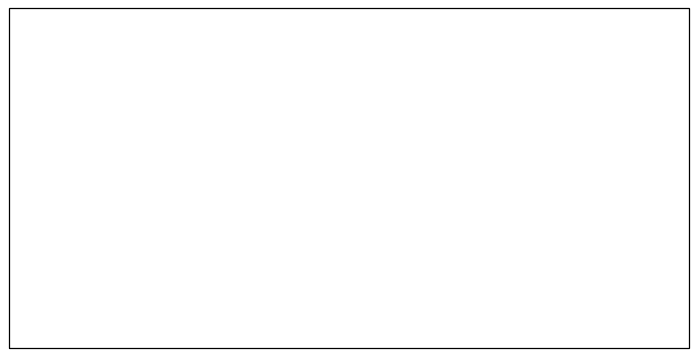

In [101]:
tile_num = 7
lons = ds.XC.isel(face=tile_num)
lats = ds.YC.isel(face=tile_num)

tile_to_plot = ds.THETA.isel(face=tile_num, time=1)
# mask to NaN where hFacC is == 0
# syntax is actually "keep where hFacC is not equal to zero"
tile_to_plot= tile_to_plot.where(ds.hFacC.isel(face=tile_num,k=0) !=0, np.nan)

plt.figure(figsize=(10,5), dpi= 90)

# here is where you specify what projection you want to use
ax = plt.axes(projection=ccrs.PlateCarree())

# here is here you tell Cartopy that the projection
# of your 'x' and 'y' are geographic (lons and lats)
# and that you want to transform those lats and lons
# into 'x' and 'y' in the projection
plt.contourf(lons, lats, tile_to_plot, 60,
             transform=ccrs.PlateCarree());

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--');
ax.coastlines()
ax.add_feature(cfeature.LAND)

plt.colorbar()

In [5]:
ds_ll = faces_dataset_to_latlon(ds)

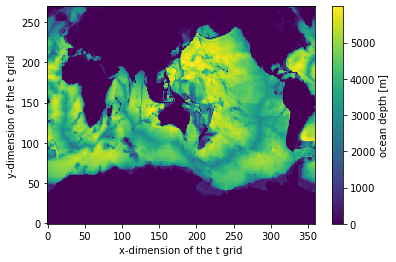

In [6]:
ds_ll.Depth.plot()

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/dataarray.py:2793: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


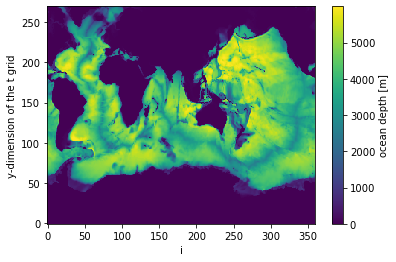

In [7]:
#ryan fixed the <i,j,k> coords
ds_ll.Depth.roll(i=50).drop('i').plot()

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/dataarray.py:2793: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


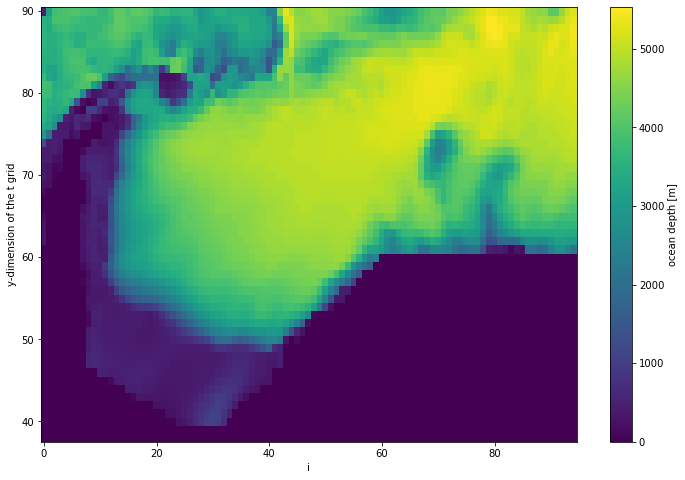

In [8]:
ds_ll.Depth.roll(i=50).drop('i').sel(i=slice(20, 115), j=slice(38, 90)).plot(figsize=(12,8))

In [9]:
ds_ll_drop = ds_ll.drop(['i', 'j', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])

In [10]:
# a trick to make things work a bit faster
coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=50, i_g=50)
ds = ds_ll_drop.reset_coords(drop=True).roll(i=50, i_g=50)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 79 #-62.216576˚ #used to be 90 

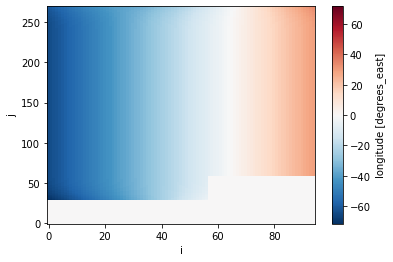

In [16]:
coords.XC.isel(i=slice(23, 118)).plot()

In [17]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))

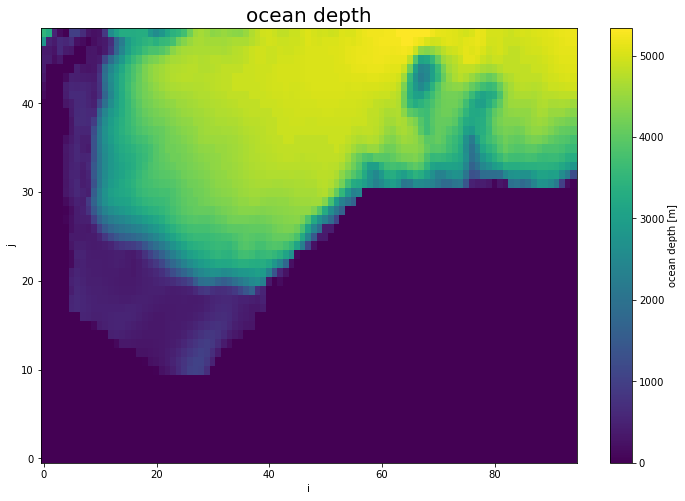

In [18]:
coords.Depth.sel(**lat_range, **lon_range).plot(figsize=(12,8))
plt.title('ocean depth', fontsize=20);

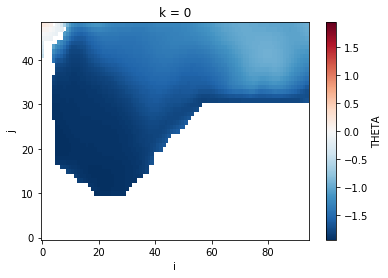

In [19]:
sst_mean = ds.THETA.sel(**lat_range, **lon_range).sel(k=0).mean(dim='time')
surface_mask = (coords.hFacC[0].isel(**lat_range, **lon_range)>0)
sst_mean.where(surface_mask).plot()

## <span style='color:Brown'> Bottom Potential Temperatures

In [20]:
#this gives us the depth of the bottom cell
depth_max = ds.k.where(coords.hFacC > 0).max(dim='k').load()

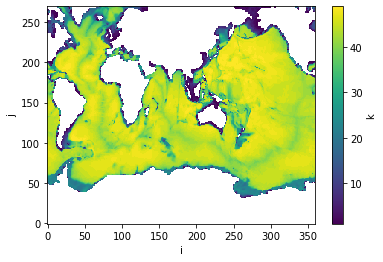

In [21]:
depth_max.plot()

In [23]:
bottom_temp = ds.THETA.mean(dim='time').isel(k=depth_max.fillna(0.).astype('i4'))

In [24]:
bottom_temp_wg = bottom_temp.isel(**lat_range, **lon_range)

In [83]:
bottom_temp_wg.load()

<xarray.DataArray 'THETA' (j: 49, i: 95)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.7710441 ,  1.761797  ,  1.3248782 , ..., -0.60652184,
        -0.60673106, -0.60680985],
       [ 0.5656107 ,  1.8291067 ,  1.680977  , ..., -0.60746765,
        -0.6074577 , -0.6074615 ],
       [ 0.13080381,  0.2509648 ,  1.8400244 , ..., -0.60863924,
        -0.6083164 , -0.608207  ]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
Dimensions without coordinates: j, i

In [85]:
bottom_temp_wg.j

<xarray.DataArray 'j' (j: 49)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])
Dimensions without coordinates: j

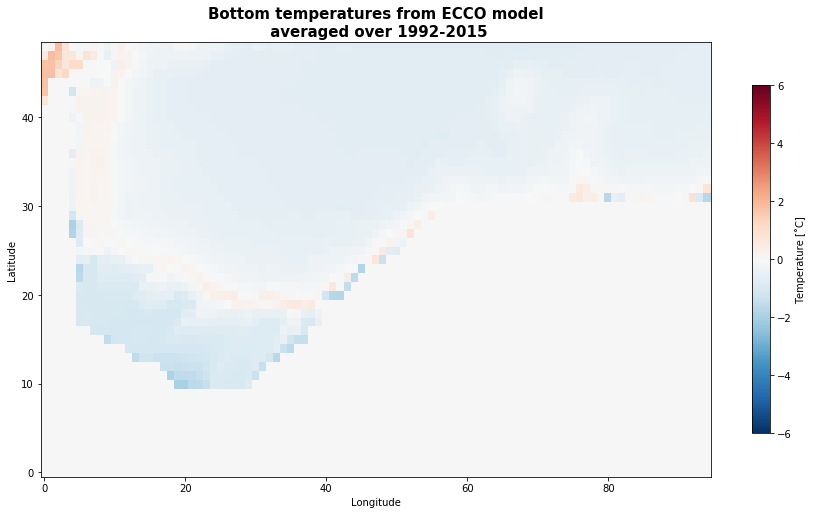

In [44]:
bottom_temp_wg.plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Temperature [˚C]'}, cmap='RdBu_r', vmax=6)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom temperatures from ECCO model\n averaged over 1992-2015', fontsize=15, weight='bold');

##  <span style='color:Magenta'> Plotting w Cartopy

In [25]:
bottom_temp_wg = xr.open_dataset('bottom_temp_wg.nc')

In [29]:
bottom_temp_wg#.j

<xarray.Dataset>
Dimensions:  (i: 95, j: 49)
Coordinates:
    k        (j, i) int64 ...
Dimensions without coordinates: i, j
Data variables:
    THETA    (j, i) float32 ...

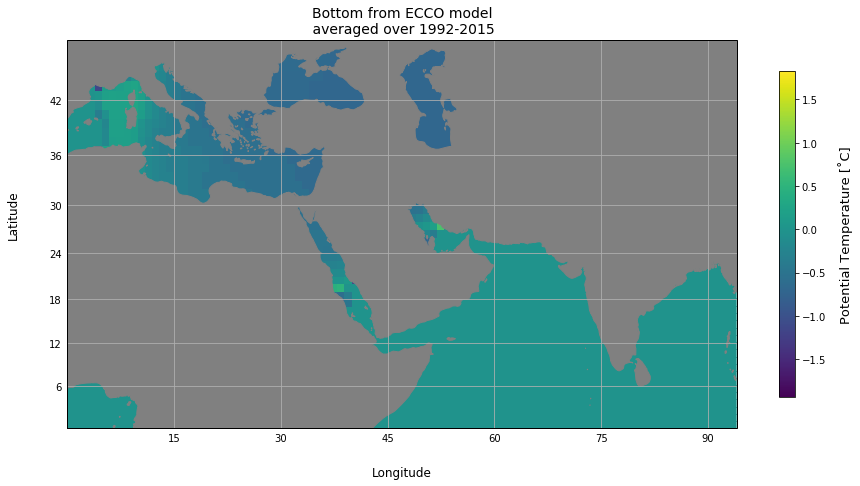

In [32]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

#ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
#ax.set_extent([0, 94, 0, 48], crs=ccrs.PlateCarree())
#ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))#cfeature.COLORS['land']))

#C = ax.contourf(pt_bottom_wg.lon, pt_bottom_wg.lat, pt_bottom_wg.PT[0], transform=ccrs.PlateCarree())#, levels=np.arange(-2, 1, 0.2))
#ax.clabel(C, colors='k')
#fig.colorbar(C, ax=ax, shrink=0.4, label='Potential Temperature [˚C]')
im = ax.pcolormesh(bottom_temp_wg.i, bottom_temp_wg.j, bottom_temp_wg.THETA, transform=ccrs.PlateCarree())
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

#ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
#basins = regionmask.defined_regions.natural_earth.ocean_basins_50
#mask = basins.mask(pt_bottom_wg.lon, pt_bottom_wg.lat)
#mask.plot(add_colorbar=False, ax=ax);
#ax.set_xlim(xmin=-78)
plt.title('Bottom from ECCO model\n averaged over 1992-2015', fontsize=14);

In [37]:
bottom_temp_wg.THETA

<xarray.DataArray 'THETA' (j: 49, i: 95)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       ...,
       [ 1.771044,  1.761797,  1.324878, ..., -0.606522, -0.606731, -0.60681 ],
       [ 0.565611,  1.829107,  1.680977, ..., -0.607468, -0.607458, -0.607462],
       [ 0.130804,  0.250965,  1.840024, ..., -0.608639, -0.608316, -0.608207]],
      dtype=float32)
Coordinates:
    k        (j, i) int64 ...
Dimensions without coordinates: j, i

In [44]:
lon = coords.XC.isel(**lat_range, **lon_range)
lat = coords.YC.isel(**lat_range, **lon_range)

In [50]:
tile_mask = lat!=0

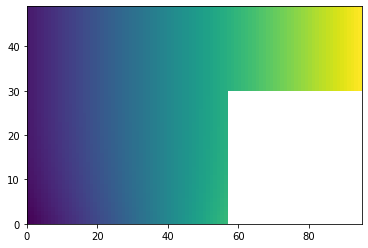

In [54]:
plt.pcolormesh(lon.where(tile_mask).to_masked_array())

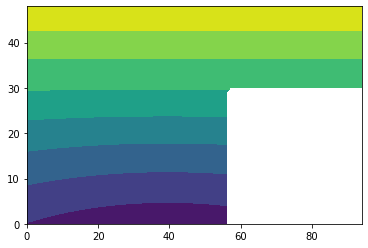

In [56]:
plt.contourf(lat.where(tile_mask).to_masked_array())

ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.core.MaskedArray with masked values

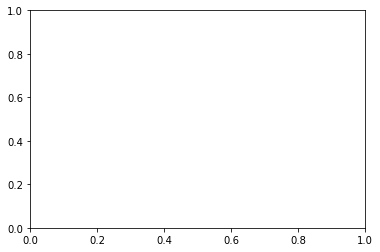

In [52]:
plt.pcolormesh(lon.where(tile_mask).to_masked_array(),
               lat.where(tile_mask).to_masked_array(),
               bottom_temp_wg.THETA)

In [87]:
from matplotlib import pyplot as plt
import cartopy as cart
import pyresample

class LLCMapper:

    def __init__(self, ds, dx=0.25, dy=0.25):
        # Extract LLC 2D coordinates
        lons_1d = ds.XC.isel(**lon_range).values.ravel()
        lats_1d = ds.YC.isel(**lat_range).values.ravel()

        # Define original grid
        self.orig_grid = pyresample.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

        # Longitudes latitudes to which we will we interpolate
        lon_tmp = np.arange(-180, 180, dx) + dx/2
        lat_tmp = np.arange(-90, 90, dy) + dy/2

        # Define the lat lon points of the two parts.
        self.new_grid_lon, self.new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
        self.new_grid  = pyresample.geometry.GridDefinition(lons=self.new_grid_lon,
                                                            lats=self.new_grid_lat)#.get_area_slices(self, area_to_cover=(**lat_range, **lon_range))

    def __call__(self, da, ax=None, projection=cart.crs.Robinson(), lon_0=-60, **plt_kwargs):

        assert set(da.dims) == set(['j', 'i']), "da must have dimensions ['j', 'i']"

        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 6))

        field = pyresample.kd_tree.resample_nearest(self.orig_grid, da.values,
                                                    self.new_grid,
                                                    radius_of_influence=100000,
                                                    fill_value=None)


        vmax = plt_kwargs.pop('vmax', field.max())
        vmin = plt_kwargs.pop('vmin', field.min())

        m = plt.axes(projection=projection)
        x,y = self.new_grid_lon, self.new_grid_lat

        # Find index where data is splitted for mapping
        split_lon_idx = round(x.shape[1]/(360/(lon_0 if lon_0>0 else lon_0+360)))


        p = m.pcolormesh(x[:,:split_lon_idx], y[:,:split_lon_idx], field[:,:split_lon_idx],
                         vmax=vmax, vmin=vmin, transform=cart.crs.PlateCarree(), zorder=1, **plt_kwargs)
        p = m.pcolormesh(x[:,split_lon_idx:], y[:,split_lon_idx:], field[:,split_lon_idx:],
                         vmax=vmax, vmin=vmin, transform=cart.crs.PlateCarree(), zorder=2, **plt_kwargs)

        m.add_feature(cart.feature.LAND, facecolor='0.5', zorder=3)
        label = ''
        if da.name is not None:
            label = da.name
        if 'units' in da.attrs:
            label += ' [%s]' % da.attrs['units']
        cb = plt.colorbar(p, shrink=0.4, label=label)
        return m, ax


In [ ]:
mapper = LLCMapper(coords_before_drop)

## Bottom Salinity

In [76]:
bottom_slt = ds.SALT.mean(dim='time').isel(k=depth_max.fillna(0.).astype('i4'))

In [77]:
bottom_slt_wg = bottom_slt.isel(**lat_range, **lon_range)

In [78]:
bottom_slt_wg.load()

<xarray.DataArray 'SALT' (j: 52, i: 95)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [34.70811 , 34.70702 , 34.70578 , ..., 34.672806, 34.671665,
        34.67085 ],
       [34.709854, 34.711884, 34.707447, ..., 34.672657, 34.671444,
        34.670635],
       [34.712265, 34.712845, 34.70824 , ..., 34.672043, 34.670845,
        34.670425]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 46 46 46 46 46 46 47 47 48
Dimensions without coordinates: j, i

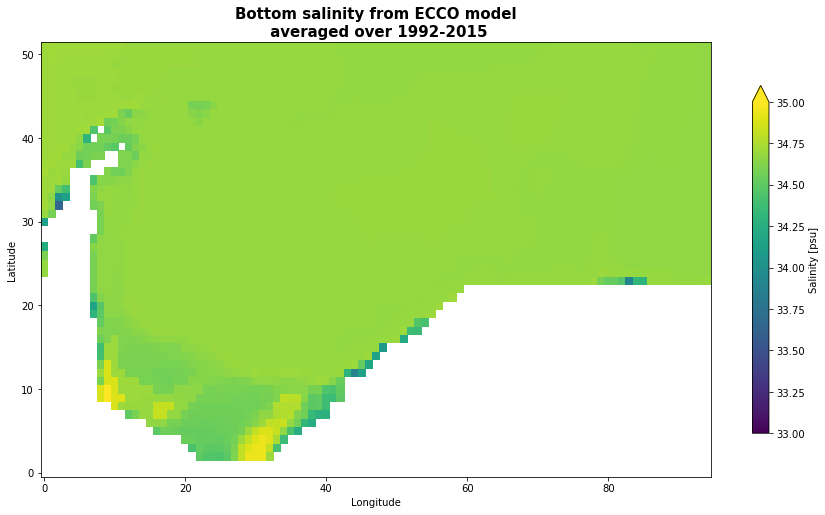

In [79]:
bottom_slt_wg.where(surface_mask).plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Salinity [psu]'}, vmin=33, vmax=35)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom salinity from ECCO model\n averaged over 1992-2015', fontsize=15, weight='bold');